In [3]:
#Spark Setup

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RetinaCNN_SparkProject") \
    .master("spark://192.168.13.119:7077") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

spark

In [2]:
#Spark Verification

df = spark.range(0, 20)
df.show()
print("Spark executors:", spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos())

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
| 11|
| 12|
| 13|
| 14|
| 15|
| 16|
| 17|
| 18|
| 19|
+---+

Spark executors: [Lorg.apache.spark.SparkExecutorInfo;@7f26aafc


In [18]:
#Imports


import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix, classification_report

print("done")

done


In [19]:
#Retinopathy Grade

label_to_grade = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

grade_to_label = {v: k for k, v in label_to_grade.items()}

In [20]:
#Dataset Loader

class RetinaDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.image_col = "Image name"
        self.label_col = "Retinopathy grade"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx][self.image_col]
        label = int(self.df.iloc[idx][self.label_col])

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [21]:
#Data Transform (For ResNet)

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
#Load Dataset and Loaders

base_dir = Path("/home/sat3812/cnn_project")

train_csv = base_dir/"train"/"annotations.csv"
valid_csv = base_dir/"valid"/"annotations.csv"
test_csv  = base_dir/"test"/"annotations.csv"

train_imgs = base_dir/"train"/"images"
valid_imgs = base_dir/"valid"/"images"
test_imgs  = base_dir/"test"/"images"

train_dataset = RetinaDataset(train_csv, train_imgs, train_transform)
valid_dataset = RetinaDataset(valid_csv, valid_imgs, test_transform)
test_dataset  = RetinaDataset(test_csv,  test_imgs,  test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [23]:
#ResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

#EarlyLayerFreezing- Important for Medical Images
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/sat3812/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


In [24]:
#Opt- Adam knows best &Loss- Important to penalize misclassification

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)

In [25]:
#Training Loop

def train_model(model, train_loader, valid_loader, epochs=20):
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss /= total

#Validation
        
        model.eval()
        valid_loss = 0
        correct_v = 0
        total_v = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                correct_v += (preds == labels).sum().item()
                total_v += labels.size(0)

        valid_acc = correct_v / total_v
        valid_loss /= total_v

        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Valid Acc={valid_acc:.4f}")

In [26]:
#Model Training Day

train_model(model, train_loader, valid_loader, epochs=20)

Epoch 1: Train Acc=0.5276, Valid Acc=0.5752
Epoch 2: Train Acc=0.5732, Valid Acc=0.5664
Epoch 3: Train Acc=0.5701, Valid Acc=0.5870
Epoch 4: Train Acc=0.5840, Valid Acc=0.5959
Epoch 5: Train Acc=0.5935, Valid Acc=0.6047
Epoch 6: Train Acc=0.6018, Valid Acc=0.5811
Epoch 7: Train Acc=0.5992, Valid Acc=0.5811
Epoch 8: Train Acc=0.5954, Valid Acc=0.6106
Epoch 9: Train Acc=0.6214, Valid Acc=0.6165
Epoch 10: Train Acc=0.6024, Valid Acc=0.5959
Epoch 11: Train Acc=0.6170, Valid Acc=0.6313
Epoch 12: Train Acc=0.6126, Valid Acc=0.6224
Epoch 13: Train Acc=0.6113, Valid Acc=0.6283
Epoch 14: Train Acc=0.6138, Valid Acc=0.5959
Epoch 15: Train Acc=0.6265, Valid Acc=0.6254
Epoch 16: Train Acc=0.6208, Valid Acc=0.6047
Epoch 17: Train Acc=0.6252, Valid Acc=0.5841
Epoch 18: Train Acc=0.6170, Valid Acc=0.6224
Epoch 19: Train Acc=0.6107, Valid Acc=0.6047
Epoch 20: Train Acc=0.6024, Valid Acc=0.6047


In [27]:
#Eval

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(
    [label_to_grade[l] for l in all_labels],
    [label_to_grade[p] for p in all_preds],
))



Confusion Matrix:
 [[173   0   3   2   0]
 [ 43   0   1   0   0]
 [ 45   0  11  20   0]
 [  5   0   3  15   2]
 [  5   0   0   9   1]]

Classification Report:
                  precision    recall  f1-score   support

            Mild       0.00      0.00      0.00        44
        Moderate       0.61      0.14      0.23        76
           No DR       0.64      0.97      0.77       178
Proliferative DR       0.33      0.07      0.11        15
          Severe       0.33      0.60      0.42        25

        accuracy                           0.59       338
       macro avg       0.38      0.36      0.31       338
    weighted avg       0.51      0.59      0.49       338



/home/sat3812/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sat3812/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/sat3812/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [36]:
#Stop session

spark.stop()

In [38]:
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        probs = torch.softmax(outputs, dim=1)
        
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [39]:
from sklearn.metrics import roc_auc_score
import numpy as np

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

auc_macro = roc_auc_score(
    all_labels,
    all_probs,
    multi_class="ovr",
    average="macro"
)

print("Macro ROC-AUC:", auc_macro)

Macro ROC-AUC: 0.8106254624361389


In [40]:
import numpy as np
import torch

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

In [41]:
from sklearn.preprocessing import label_binarize

n_classes = 5
y_test_bin = label_binarize(all_labels, classes=[0,1,2,3,4])

In [42]:
from sklearn.metrics import roc_auc_score

auc_per_class = {}

for i in range(n_classes):
    auc_score = roc_auc_score(y_test_bin[:, i], all_probs[:, i])
    auc_per_class[f"Class {i}"] = auc_score

auc_per_class

{'Class 0': 0.8314606741573034,
 'Class 1': 0.6634199134199135,
 'Class 2': 0.7504519887505022,
 'Class 3': 0.9037699680511182,
 'Class 4': 0.9040247678018576}

In [47]:
idx_to_label = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR",
}

label_names = [idx_to_label[i] for i in range(5)]

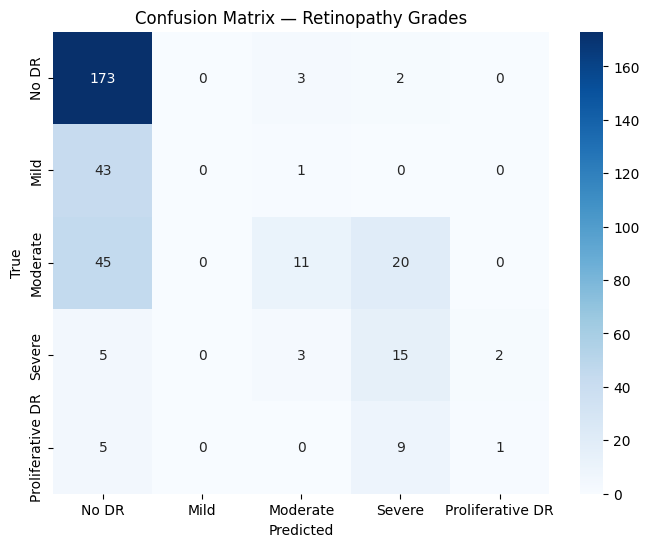

In [48]:
#Confusion Matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Retinopathy Grades")
plt.show()

In [49]:
label_names = [
    "No DR", 
    "Mild", 
    "Moderate", 
    "Severe", 
    "Proliferative DR"
]

In [51]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

num_classes = 5

label_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

y_true_bin = label_binarize(all_labels, classes=[0,1,2,3,4])
y_score = np.array(all_probs)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

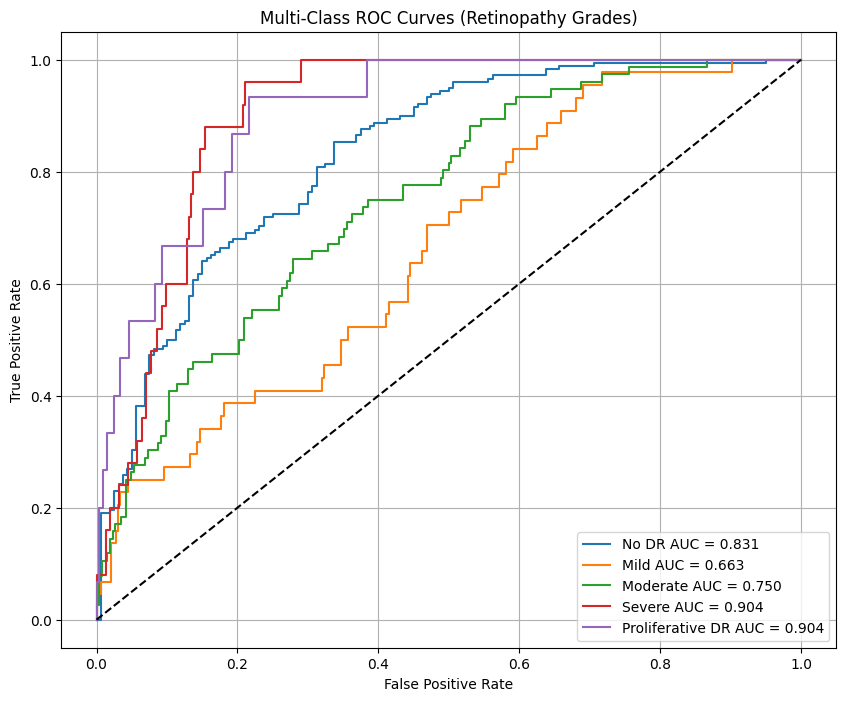

In [52]:
plt.figure(figsize=(10,8))

for i in range(num_classes):
    plt.plot(
        fpr[i], tpr[i],
        label=f"{label_names[i]} AUC = {roc_auc[i]:.3f}"
    )

plt.plot([0,1], [0,1], linestyle='--', color='black')

plt.title("Multi-Class ROC Curves (Retinopathy Grades)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()